In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as img
from sklearn.metrics import f1_score 
import tensorflow as tf
import pathlib
import random

In [2]:
df_train = pd.read_csv('D:/March-2025/project/own/Fetal_Brain/Dataset/train.csv')
df_test = pd.read_csv('D:/March-2025/project/own/Fetal_Brain/Dataset/test.csv')
submission = pd.read_csv('D:/March-2025/project/own/Fetal_Brain/Dataset/sample_submission.csv')

IMAGE_SIZE = (256, 256, 1)

data_dir = pathlib.Path('D:/March-2025/project/own/Fetal_Brain/Dataset/data/data/')

In [4]:
df_train['image_name'] = df_train['image_name'].apply(lambda x : x + '.png' )
df_test['image_name'] = df_test['image_name'].apply(lambda x : x + '.png' )

In [5]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2,shear_range=0.2,
                                       rotation_range=20,
                                       brightness_range=[0.4,1.5])

In [6]:
train_ds = datagen.flow_from_dataframe(dataframe=df_train,
                                       directory=data_dir,
                                       x_col = 'image_name',
                                       y_col = 'class',
                                       subset='training',
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       seed=43,
                                       target_size=IMAGE_SIZE[:-1],
                                       batch_size=32)

valid_ds = datagen.flow_from_dataframe(dataframe=df_train,
                                       directory=data_dir,
                                       x_col = 'image_name',
                                       y_col = 'class',
                                       subset='validation',
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       seed=43,
                                       target_size=IMAGE_SIZE[:-1],
                                       batch_size=32)
test_ds = datagen.flow_from_dataframe(dataframe=df_test,
                                       directory=data_dir,
                                       x_col = 'image_name',
                                       class_mode=None,
                                       color_mode='rgb',
                                       target_size=IMAGE_SIZE[:-1],
                                       batch_size=32)

Found 2000 validated image filenames belonging to 4 classes.
Found 500 validated image filenames belonging to 4 classes.
Found 592 validated image filenames.


In [7]:
import tensorflow.keras.backend as K

In [8]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [9]:
from tensorflow.keras.optimizers import Adam 

In [10]:
model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
        
])

C:\Program Files\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[get_f1])
history = model.fit(train_ds, epochs=10, batch_size=32, shuffle=True, validation_data=valid_ds)

Epoch 1/10


C:\Program Files\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 528s 8s/step - get_f1: 0.2695 - loss: 1.4213 - val_get_f1: 0.5753 - val_loss: 0.9956
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 457s 7s/step - get_f1: 0.4535 - loss: 1.0347 - val_get_f1: 0.5018 - val_loss: 0.9602
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - get_f1: 0.4978 - loss: 0.9551 - val_get_f1: 0.5694 - val_loss: 0.9132
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - get_f1: 0.5559 - loss: 0.9007 - val_get_f1: 0.5837 - val_loss: 0.9384
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - get_f1: 0.6147 - loss: 0.8205 - val_get_f1: 0.5888 - val_loss: 0.9102
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 582s 9s/step - get_f1: 0.6490 - loss: 0.7788 - val_get_f1: 0.5831 - val_loss: 0.9175
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - get_f1: 0.6515 - loss: 0.7693 - val_get_f1: 0.6022 - val_loss: 0.9311
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - get_f1: 0.7110 - loss: 0.6633 - val_get_f1: 0.5752 - val_loss: 1.0261
Epoch 9/10
63/63 ━━━━━━━━━━

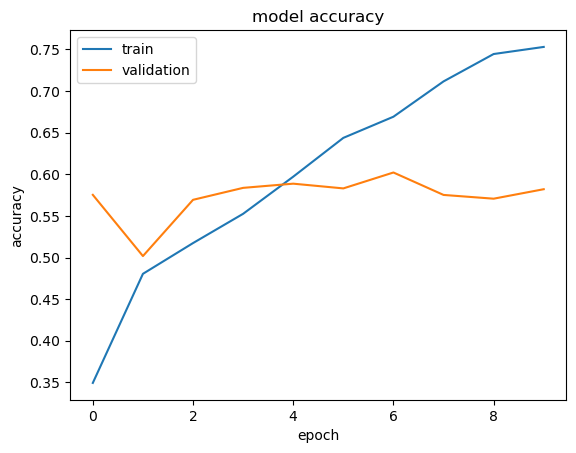

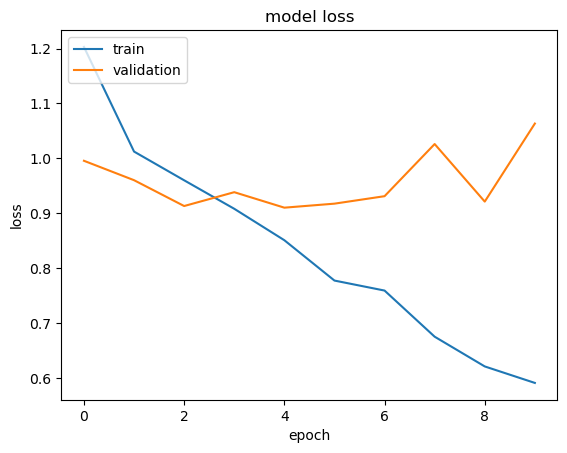

In [12]:
# summarize history for accuracy
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
model.save("Fetal_Brain.h5")

Found 334 images belonging to 4 classes.
Found 83 images belonging to 4 classes.
Found 144 images belonging to 4 classes.
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 634s 59s/step - accuracy: 0.2925 - loss: 3.8284 - val_accuracy: 0.2771 - val_loss: 2.5314
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 345s 31s/step - accuracy: 0.3897 - loss: 2.0718 - val_accuracy: 0.4217 - val_loss: 1.5980
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 377s 35s/step - accuracy: 0.6978 - loss: 0.8008 - val_accuracy: 0.4458 - val_loss: 1.4760
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 367s 33s/step - accuracy: 0.7188 - loss: 0.7724 - val_accuracy: 0.4337 - val_loss: 1.5553
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 469s 44s/step - accuracy: 0.8073 - loss: 0.6408 - val_accuracy: 0.3976 - val_loss: 1.5942
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 383s 36s/step - accuracy: 0.8026 - loss: 0.6059 - val_accuracy: 0.4578 - val_loss: 1.4887
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 313s 28s/step - accuracy: 0.8009 - loss: 0.5546 - val_accuracy: 0.4699 -

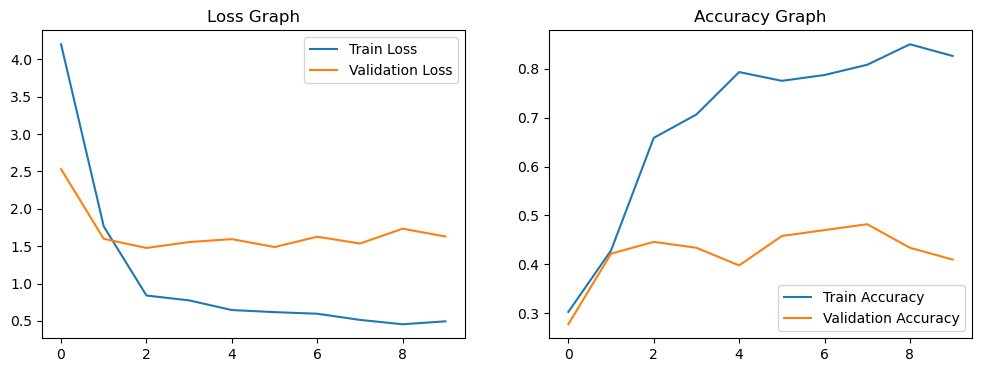

5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 8s/step
                   precision    recall  f1-score   support

            Other       0.65      0.72      0.68        36
 Trans-cerebellum       0.81      0.58      0.68        36
   Trans-thalamic       0.44      0.75      0.56        36
Trans-ventricular       0.94      0.44      0.60        36

         accuracy                           0.62       144
        macro avg       0.71      0.62      0.63       144
     weighted avg       0.71      0.62      0.63       144



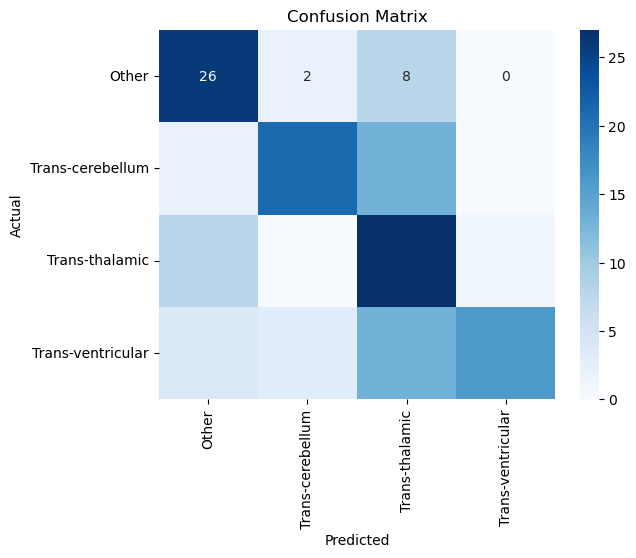

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess dataset
data_dir = "D:/March-2025/project/own/Fetal_Brain/data/train"  # Update with your dataset path
img_size = (224, 224)
batch_size = 32

# Data Augmentation & Splitting
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% for validation

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load Test Data (Separate Folder)
test_dir = "D:/March-2025/project/own/Fetal_Brain/data/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load Pretrained VGG19 Model
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Define Model
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Graph')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Graph')
plt.show()

# Evaluate Model on Test Data
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the Model
model.save("FETAL_BRAIN_UPDATE.h5")
